## 라이브러리 import

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from urllib.parse import urlencode, quote_plus, unquote
import json
from urllib.request import *
from xml.etree.ElementTree import *
from math import *
import datetime
import pytz
import gmaps
import gmaps.datasets
import datetime
import time
import re
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


## 날씨 가져오는 함수들

In [61]:
def get_weather_data(longi, latit, key="...."):
    grib_date, grib_time = get_grib_date()
    grib_url = "http://newsky2.kma.go.kr/service/SecndSrtpdFrcstInfoService2/ForecastGrib?"
    forecast_date, forecast_time = get_forecast_date()
    forecast_url = "http://newsky2.kma.go.kr/service/SecndSrtpdFrcstInfoService2/ForecastTimeData?"
    nx, ny = longitude_and_latitude_to_cartesian(longi, latit)

    grib = urlopen(grib_url+"serviceKey="+key+"&base_date="+grib_date+"&base_time="+grib_time+"&nx="+nx+"&ny="+ny).read().decode("utf-8")
    forecast = urlopen(forecast_url+"serviceKey="+key+"&base_date="+forecast_date+"&base_time="+forecast_time+"&nx="+nx+"&ny="+ny).read().decode("utf-8")

    grib_data = fromstring(grib)  # 초단기 실황
    forecast_data = fromstring(forecast)  # 초단기 예보
    # 초단기 날씨 상황에는 정보 누락이 있을 수 있음

    data_parsed = {"T1H":"None", "RN1":"None", "PTY":"None", "SKY":"None", "LGT":"None", "WSD":"None"}
    for item in forecast_data[1][0]:
        if item[2].text in list(data_parsed.keys()):
            data_parsed[item[2].text] = item[5].text
    for item in grib_data[1][0]:
        if item[2].text in list(data_parsed.keys()):
            data_parsed[item[2].text] = item[5].text

    return data_parsed

In [62]:
def get_grib_date():
    now = datetime.datetime.now(tz=pytz.timezone("Asia/Seoul"))
    date_now = now.strftime("%Y%m%d")
    time_now = now.strftime("%H") + "00"

    return date_now, time_now

In [63]:
def get_forecast_date():
    now = datetime.datetime.now(tz=pytz.timezone("Asia/Seoul"))
    min_chk = datetime.datetime.now(tz=pytz.timezone("Asia/Seoul")).strftime("%M")

    if int(min_chk) < 30:
        now -= datetime.timedelta(hours=1)
    date_now = now.strftime("%Y%m%d")
    time_now = now.strftime("%H") + "30"

    return date_now, time_now

In [64]:
def longitude_and_latitude_to_cartesian(longitude, latitude):
    lon = float(longitude)
    lat = float(latitude)

    _Re = 6371.00877
    _grid = 5
    _slat1 = 30
    _slat2 = 60
    _olon = 126
    _olat = 38
    _xo = 210 / _grid
    _yo = 675 / _grid

    DEGRAD = pi / 180.0
    RADDEG = 180.0 / pi

    re = _Re / _grid
    slat1 = _slat1 * DEGRAD
    slat2 = _slat2 * DEGRAD
    olon = _olon * DEGRAD
    olat = _olat * DEGRAD

    sn = tan(pi * 0.25 + slat2 * 0.5) / tan(pi * 0.25 + slat1 * 0.5)
    sn = log(cos(slat1) / cos(slat2)) / log(sn)
    sf = tan(pi * 0.25 + slat1 * 0.5)
    tmp = sf ** sn if sf > 0 else -(abs(sf) ** sn)
    sf = tmp * cos(slat1) / sn
    ro = tan(pi * 0.25 + olat * 0.5)
    ro = re * sf / (ro ** sn if ro > 0 else -(abs(ro) ** sn))

    ra = tan(pi * 0.25 + lat * DEGRAD * 0.5)
    ra = re * sf / (ra ** sn if ra > 0 else -(abs(ra) ** sn))
    theta = lon * DEGRAD - olon
    if theta > pi:
        theta -= 2.0 * pi
    if theta < -pi:
        theta += 2.0 * pi
    theta *= sn
    x = ra * sin(theta) + _xo
    y = (ro - ra * cos(theta)) + _yo

    return str(int(x+1.5)), str(int(y+1.5))

## 미세먼지 가져오기

In [1]:
url = 'http://openapi.airkorea.or.kr/openapi/services/rest/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty'
service_key = '.......' # FIXME
stationName = '광진구' # FIXME

In [66]:
decode_key = unquote(service_key)
queryParams = '?' + urlencode({ quote_plus('ServiceKey') : decode_key, quote_plus('stationName'): stationName, quote_plus('dataTerm'): 'daily', quote_plus('_returnType'): 'json', quote_plus('ver'): '1.3', quote_plus('pageNo'): 1})

request = Request(url + queryParams)
request.get_method = lambda: 'GET'
response_body = urlopen(request).read()

response_body = json.loads(response_body)

### 날씨 및 미세먼지 변수 만들기

In [2]:
long = 127.073092  # put longitude
lati = 37.550208  # put latitude
weather_dict = get_weather_data(long, lati)
fine_dust = response_body['list'][0]['pm10Grade']
Ultrafine_dust = response_body['list'][0]['pm25Grade']
dataTime = response_body['list'][0]['dataTime']

NameError: name 'get_weather_data' is not defined

### 날씨 : weather_dict , 미세먼지 : fine_dust , 초미세먼지 : Ultrafine_dust , 미세먼지 시간 : dataTime

#### weather_dict
    # | 등급	| 좋음 | 보통 |	나쁨 | 매우나쁨 |  
    # | Grade |	 1   |	2   |	3  |    4     |

#### fine_dust
    # T1H : 기온
    # RN1 : 1시간 강수량
    #       (0 - 0mm 또는 없음)
    #       (1 - 1mm 미만)
    #       (5 - 1~4mm)
    #       (10 - 5~9mm)
    #       (20 - 10~19mm)
    #       (40 - 20~39mm)
    #       (70 - 40~69mm)
    #       (100 - 70mm 이상)
    # PTY : 강수형태 -- 0 - 없음 , 1 - 비 , 2 - 진눈깨비 , 3 - 눈
    # SKY : 하늘상태 -- 1 - 맑음 , 2 - 구름조금 , 3 - 구름많음 , 4 - 흐림
    # LGT : 낙뢰 -- 0 - 없음 , 1 - 있음
    #          또는 0 - 없음 , 1 - 낮음 , 2 - 보통 , 3 - 높음
    # WSD : 풍속

In [68]:
print ("추출 시간   : ",dataTime)
print ("미세먼지    : ",fine_dust)
print ("초 미세먼지 : ",Ultrafine_dust)
print ("기온        : ",weather_dict["T1H"])
print ("강수량      : ",weather_dict["RN1"])
print ("강수형태    : ",weather_dict["PTY"])
print ("하늘상태    : ",weather_dict["SKY"])
print ("낙뢰        : ",weather_dict["LGT"])
print ("풍속        : ",weather_dict["WSD"])

시간        :  2018-11-06 15:00
미세먼지    :  3
초 미세먼지 :  3
기온        :  None
강수량      :  0
강수형태    :  0
하늘상태    :  4
낙뢰        :  0
풍속        :  None


### 데이터 보기

In [4]:
df = pd.read_csv("Seoul_Place.csv")

### 데이터 위치 출력

In [2]:
gmaps.configure(api_key="...") # Your Google API key

In [71]:
df2 = df[['Latitude','Longitude']]
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(df2))
fig

Figure(layout=FigureLayout(height='420px'))

# MAIN CODE

In [5]:
Longitude=12700
Latitude=3755
O = 5
A = 1
t = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tt = datetime.datetime.now()
n = time.localtime().tm_wday
print (t[n],tt.hour,tt.minute)

Thursday 18 24


In [6]:
df["Longitude"]=df["Longitude"]*100
df["Latitude"]=df["Latitude"]*100

## Open시간 필터링

In [7]:
tt = datetime.datetime.now()
print (t[n],tt.hour,tt.minute, tt.second)

Thursday 18 24 16


In [8]:
df[t[n]] = df[t[n]].fillna("Open 24 hours")

In [9]:
def Find_Hours_of_use(zz):
    p1 = re.compile('(AM)+')
    m1 = p1.search(zz)
    p2 = re.compile('(PM)+')
    m2 = p2.search(zz)
    p3 = re.compile('(:)+')
    m3 = p3.search(zz)
    p5 = re.compile('(–)+')
    m5 = p5.search(zz)

    i11 = int(re.findall('\d+', str(m1))[0])
    i12 = int(re.findall('\d+', str(m1))[1])
    i21 = int(re.findall('\d+', str(m2))[0])
    i22 = int(re.findall('\d+', str(m2))[1])
    i51 = int(re.findall('\d+', str(m5))[0])
    i52 = int(re.findall('\d+', str(m5))[1])
    if(m3):
        i31 = int(re.findall('\d+', str(m3))[0])
        i32 = int(re.findall('\d+', str(m3))[1])
        z2=zz
        if(i31<i51):
            z2 = zz[i32:]
        p4 = re.compile('(:)+')
        m4 = p4.search(z2)
        if(m4):
            i41 = int(re.findall('\d+', str(m4))[0])
            i42 = int(re.findall('\d+', str(m4))[1])
            p5 = re.compile('(–)+')
            m5 = p5.search(z2)
        else:
            i41 = None
            i42 = None
    else:
        i31 = None
        i32 = None
        z2 = None
        i41 = None
        i42 = None

    i51 = int(re.findall('\d+', str(m5))[0])
    i52 = int(re.findall('\d+', str(m5))[1])
    
    if (i31 and i31<i51):
        openss = zz[:i11]
        opensss = int(openss[:i31])*60 + int(openss[i32:])
    else:
        opensss = int(zz[:i11])*60 

    if i41:
        closs = z2[i52:]
        i41 -= len(z2)-len(closs)
        i42 -= len(z2)-len(closs)
        closss = int(closs[:i41])*60 + int(closs[i42:-2])
    else:
        closss = int(zz[i52:-2])*60

    return opensss,closss+12*60

In [10]:
def Make_Hours_of_use(timessss,p):
    if(timessss!="Open 24 hours" and timessss!="Closed"):
        return (Find_Hours_of_use(timessss)[p])
    elif(timessss=="Open 24 hours"):
        return (p*24*60)
    elif(timessss=="Closed"):
        return (-1)

In [11]:
#[set(df["Saturday"]),set(df["Sunday"]),set(df["Monday"]),set(df["Tuesday"]),set(df["Wednesday"]),set(df["Thursday"]),set(df["Friday"])]
#set(df[t[n]])

In [12]:
opentime=[]
closetime=[]
for dftn in df[t[n]]:
    opentime.append(Make_Hours_of_use(dftn,0))
    closetime.append(Make_Hours_of_use(dftn,1))

In [13]:
df["opentime"]=opentime
df["closetime"]=closetime

In [14]:
now = tt.hour*60 + tt.minute
now

1104

In [15]:
df= df[(df["opentime"]<now) & (now<df["closetime"])]

In [16]:
df

,Name,Function,Details,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Score,NumOfReviews,Indoor/Outdoors,Longitude,Latitude,Image,opentime,closetime
2,Seoul Namsan Tower,Tower,대한민국을 대표하는 명실상부한 랜드마크 중 하나. 서울의 대표적인 랜드마크 중 하나...,10AM–12AM,10AM–11PM,10AM–11PM,10AM–11PM,10AM–11PM,10AM–11PM,10AM–11PM,4.4,"16,784",Indoor,12698.60326,3755.11694,N Seoul Tower.jpg,600,1380
5,Lotte World,Theme Park,"서울특별시 송파구 올림픽로 240(잠실동)에 위치한 건물로, 테마파크, 백화점, 호...",9:30AM–11PM,Closed,9:30AM–10PM,9:30AM–10PM,9:30AM–10PM,9:30AM–10PM,9:30AM–11PM,4.2,"13,061",Indoor/Outdoors,12709.69224,3751.12808,Lotte World.jpg,570,1320
6,Namsan Park,Park,서울특별시 중구와 용산구 사이에 있는 서울 시립공원. 예전에는 '한양공원(漢陽公園)...,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,4.5,179,Outdoor,12698.87051,3755.09895,Namsan Park.jpg,0,1440
7,Namdaemun Market,Market,서울특별시 중구 회현동 숭례문 앞에 위치해 있는 서울특별시 도심 최대의 전문 재래시장.,NaN,NaN,NaN,NaN,NaN,Open 24 hours,NaN,4.1,"7,997",Outdoor,12697.54752,3755.91786,Namdaemun Market.jpg,0,1440
8,Cheonggyecheon,Tourist Attraction,서울의 한복판인 종로구와 중구와의 경계를 흐르는 하천. 한성(서울)내의 모든 물이 ...,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,4.1,"1,301",Outdoor,12702.24388,3757.13521,Cheonggyecheon.jpg,0,1440
9,Deoksugung,Palace,서울특별시 중구 세종대로 99(정동 5-1) 서울특별시청 건너편에 있는 조선 시대에...,9AM–9PM,9AM–9PM,Closed,9AM–9PM,9AM–9PM,9AM–9PM,9AM–9PM,4.4,"5,077",Outdoor,12697.01883,3756.64117,Deoksugung.jpg,540,1260
14,Jongmyo Shrine,Historical Landmark,조선 시대 역대 왕과 왕비 및 추존된 왕과 왕비의 신주(神主)를 모신 왕실의 유교 ...,NaN,NaN,NaN,NaN,NaN,Open 24 hours,NaN,4.5,237,Outdoor,12699.19490,3757.45830,Jongmyo Shrine.jpg,0,1440
15,The National Folk Museum of Korea,Museum,고유한 민속 자료의 수집·보존·전시와 이와 연관된 체계적인 조사·연구를 위해 설립된...,9AM–7PM,9AM–7PM,9AM–6:30PM,9AM–6:30PM,9AM–6:30PM,9AM–6:30PM,9AM–6:30PM,4.4,626,Indoor,12697.68008,3758.16456,The National Folk Museum of Korea.jpg,540,1110
16,Blue House,Government Office,서울 종로구에 있는 대한민국 대통령의 관저.,NaN,NaN,NaN,NaN,NaN,Open 24 hours,NaN,3.4,455,Indoor,12697.02079,3758.16452,Blue House.jpg,0,1440
17,Gwanghwamun Square,Plaza,서울특별시 종로구 광화문에서 세종로사거리와 청계광장으로 이어지는 세종로 중앙에 조성...,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,4.4,"1,927",Outdoor,12697.45810,3757.40339,Gwanghwamun Square.jpg,0,1440


## 날씨 필터링

In [ ]:
if 날씨 나쁨 :
    df= df[df[Indoor/Outdoors]=="Indoor"]

## 거리 필터링

In [74]:
def Distance_filtering(df,lo,la,Odistance,Adistance):
    df1 =  df[(lo-Odistance <= df['Longitude'] ) & (df['Longitude'] <=lo+Odistance )]
    df2 = df1[(la-Adistance <= df['Latitude'] ) & (df['Latitude'] <=la+Adistance )]
    return df2

In [75]:
while 1:
    Fdf = Distance_filtering(df,Longitude,Latitude,O,A)
    if 10 > len(Fdf["Name"]):
        O+=0.1
        A+=0.02
    else:
        break
len(Fdf["Name"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


10

### 빈것들 0으로 채우기

In [ ]:
Fdf = Fdf.fillna(0)
Fdf

## Score 계산

In [77]:
Score = list(Fdf["Score"])
while(1):
    try:
        Score.remove(0)
    except:
        break
Score

[4.4, 4.5, 4.1, 4.3, 4.5, 4.4, 4.2, 3.8, 4.0, 4.2]

### 초기화
    0점으로 즉 비여있는 값들을 제일 낮은 점수 -1로 바꾸기

In [78]:
zidx = Fdf[Fdf["Score"]==0].index.tolist() 
ms = min(Score)-1

for i in zidx:
    Fdf.loc[i,'Score'] = ms

### Score 날씨 기반으로 변경

In [ ]:
idx = Fdf.index.tolist()
for i in idx:
    Fdf.loc[i,'Score'] =....

Fdf

### Score 거리 기반으로 변경

In [ ]:
idx = Fdf.index.tolist()
for i in idx:
    Fdf.loc[i,'Score'] = Fdf.loc[i,'Score'] + (abs(Longitude - Fdf.loc[i,'Longitude'])) + (abs(Latitude - Fdf.loc[i,'Latitude']))

Fdf

### Score 추출 및 확률화

In [81]:
roulette_dic = {}
for i in idx:
    roulette_dic[i] = Fdf.loc[i,'Score']

roulette_dic

{2: 5.9136800000018415,
 6: 5.728439999999409,
 7: 7.470340000000396,
 12: 7.895849999998791,
 26: 8.627300000001014,
 39: 5.949299999999676,
 45: 5.9031999999999245,
 48: 6.0831700000001545,
 59: 7.829009999999926,
 60: 8.474189999998725}

In [82]:
r_score_l = list(roulette_dic.values())
len(r_score_l), sum(r_score_l)

(10, 69.87447999999985)

In [83]:
for i,s in roulette_dic.items():
    roulette_dic[i]= s/sum(r_score_l)
    
roulette_dic

{2: 0.08463290174040443,
 6: 0.08198186233370784,
 7: 0.10691084928289145,
 12: 0.1130004831520579,
 26: 0.1234685395869999,
 39: 0.0851426729758803,
 45: 0.0844829185133104,
 48: 0.08705853696514332,
 59: 0.11204391073822578,
 60: 0.1212773247113788}

In [84]:
r_index_l = list(roulette_dic)
r_index_l

[2, 6, 7, 12, 26, 39, 45, 48, 59, 60]

### 최종 추천 장소 뽑기 및 출력

In [85]:
np.random.choice(r_index_l, p=list(roulette_dic.values()))

59

In [86]:
find_place_idx = np.random.choice(r_index_l, p=list(roulette_dic.values()))
find_place = Fdf.loc[find_place_idx]
find_place

Name                                              Seoul Namsan Tower
Function                                                       Tower
Details            대한민국을 대표하는 명실상부한 랜드마크 중 하나. 서울의 대표적인 랜드마크 중 하나...
Saturday                                                   10AM–12AM
Sunday                                                     10AM–11PM
Monday                                                     10AM–11PM
Tuesday                                                    10AM–11PM
Wednesday                                                  10AM–11PM
Thursday                                                   10AM–11PM
Friday                                                     10AM–11PM
Score                                                        5.91368
NumOfReviews                                                  16,784
Indoor/Outdoors                                               Indoor
Longitude                                                    12698.6
Latitude                          

Seoul Namsan Tower
분류 :  Tower


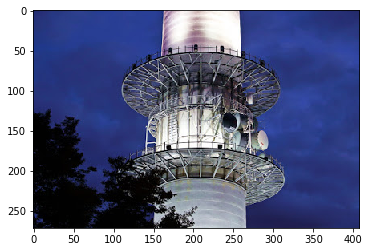

설명 :  대한민국을 대표하는 명실상부한 랜드마크 중 하나. 서울의 대표적인 랜드마크 중 하나. 타워 자체의 높이는 236.7m로, 에펠탑이나 도쿄 타워 등 다른 랜드마크에 비하면 낮은 높이지만 남산의 해발고도까지 합하면 479.7m가 된다. 전망대는 CJ푸드빌에서, 지하 상업시설은 YTN에서 운영하고 있다.


In [89]:
print(find_place["Name"])
print("분류 : ",find_place["Function"])
img=mpimg.imread('crawler/'+find_place["Image"])
imgplot = plt.imshow(img)
plt.show()

print("설명 : ",find_place["Details"])